## Study if x parameter (L.._x columns) affects average user count in network

Study how a change in cell specific parameter value “_x” affects the
average user count in the network

- Cell specific columns "_x", does it matter if measured together e.g. get mean of all "_x" or individual effects?
<br>
- Average user count, average of all cells during a measurement or does one cell already represent the average?
<br>
- Network meaning all cells or just target cell?

In [1]:
import pandas
df = pandas.read_csv('users.csv', sep=';')

In [ ]:
# helper functions

In [131]:
def get_candidate_column_names(df):
    candidate_columns = [column for column in df.columns if column[-1]==('x')]
    return candidate_columns

In [139]:
def get_columns(df, column_names):
    copy_df = df.copy()
    return copy_df[column_names]

In [115]:
def get_all_sideeffect_cols(df, candidate_cols, include_target=False):
    all_except_candidate = [column for column in df.columns if column not in candidate_columns]
    if include_target:
        other_excluded_cols = ['Time', 'Day', 'Hour', 'Rownum',]
    else:
        other_excluded_cols = ['Time', 'Day', 'Hour', 'Rownum', 'L1547777',]
    side_effect_cols = [column for column in all_except_candidate if column not in other_excluded_cols]
    return side_effect_cols

In [70]:
def get_mean_of_column_rows(df, columns=None):
    copy_df = df.copy()
    if columns:
        mean_series = copy_df[columns].agg('mean', axis='columns')
    else:
        mean_series = copy_df.agg('mean', axis='columns')
    return mean_series

In [71]:
def get_sum_of_column_rows(df, columns=None):
    copy_df = df.copy()
    if columns:
        sum_series = copy_df[columns].agg('sum', axis='columns')
    else:
        sum_series = copy_df.agg('sum', axis='columns')
    return sum_series

In [72]:
def comma_string_to_float(string_with_comma):
    return float(string_with_comma.replace(',', '.'))

In [73]:
def clean_and_convert_to_floats(df, columns):
    copy_df = df.copy()
    cleaned_df = copy_df[columns].applymap(lambda x: comma_string_to_float(x))
    return cleaned_df

In [91]:
def get_time_column_readable(df):
    from datetime import datetime
    time_df = df.copy()
    time = time_df['Time'].apply(lambda x: datetime.fromtimestamp(x))
    return time

Test 1:
Hypothesis is to measure if a mean of candidate column values affect average user count of target and rest of the side-effects

Separate the dataframe to different sections to calulate mean:

In [92]:
candidate_columns = get_candidate_column_names(df)
side_effect_columns = get_all_sideeffect_cols(df, candidate_columns)



Clean data for the columns and calculate means

In [93]:
candidate_mean = get_mean_of_column_rows(df, candidate_columns)
candidate_sum = get_sum_of_column_rows(df, candidate_columns)

In [94]:
target_df = df.copy()
target = target_df['L1547777'].apply(lambda x: comma_string_to_float(x))

In [95]:
side_effect_df = clean_and_convert_to_floats(df, side_effect_columns)
side_effect_average_user_count_mean = get_mean_of_column_row(side_effect_df)

Transform timestamp column values into readable time values

Combine data columns to one dataframe for normalisation

In [96]:
combined_df = pandas.DataFrame()
combined_df['target_count'] = target
combined_df['avg_user_count'] = side_effect_average_user_count_mean
combined_df['candidate_x_sum'] = candidate_sum
combined_df['candidate_x_mean'] = candidate_mean

Data contains some outlier training rows. Remove the rows and apply normalisation

In [97]:
normalised_df = combined_df.copy()
normalised_df = normalised_df.drop([498, 499, 500])
normalised_df = normalised_df.apply(lambda x: x/x.max())
# Add date after other columns normalised
normalised_df['datetime'] = get_time_column_readable(df)

Plot 1

<AxesSubplot:xlabel='datetime'>

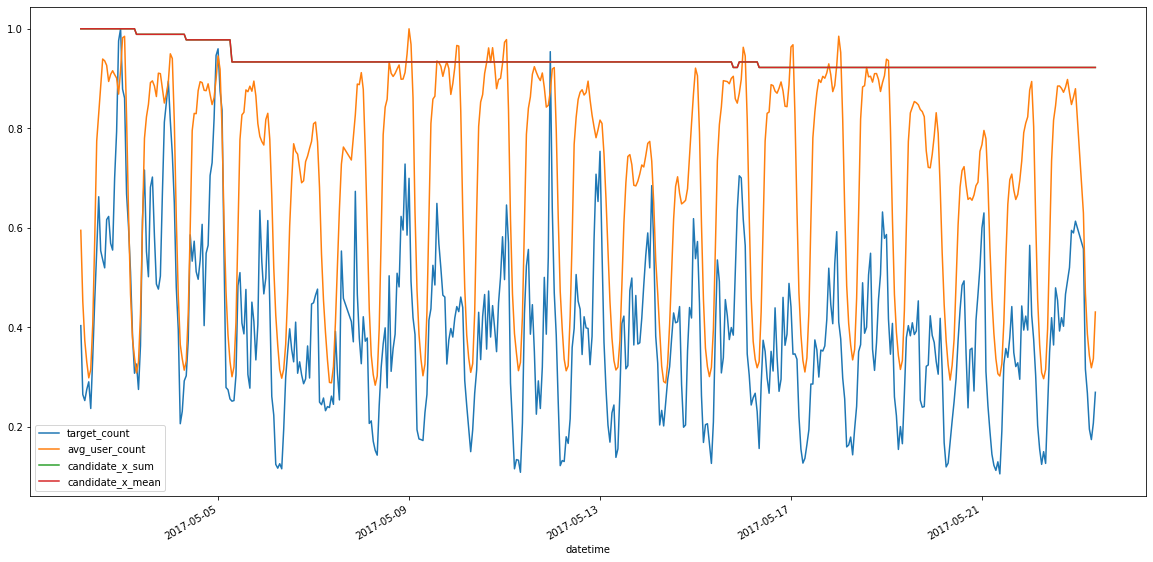

In [98]:
normalised_df.plot(x='datetime', figsize=(20,10))

Plot 1 does not show any visually significant affect that candidate column mean has on average user count for the network 

Plot 2 to visualize the columns separartely

array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>],
      dtype=object)

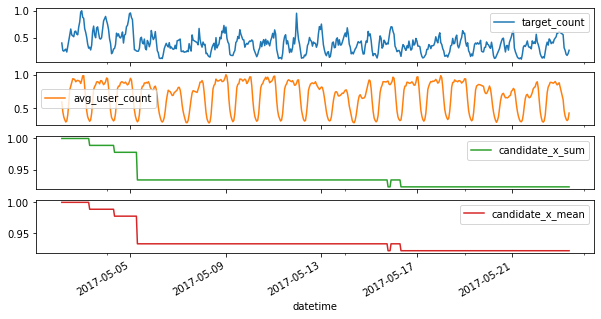

In [99]:
normalised_df.plot(x='datetime', subplots=True, figsize=(10,5))

No significant correlations between the mean of candidate columns and avg use count

Test 2:
    compare target with target_x

In [112]:
target_df = pandas.DataFrame()
target_df['target'] = df['L1547777'].apply(lambda x: comma_string_to_float(x))
target_df['target_x'] = df['L1547777_x']
target_df.drop([498, 499, 500,])

,target,target_x
0,6.31,32
1,4.14,32
2,3.95,32
3,4.30,32
4,4.54,32
...,...,...
503,4.18,26
504,3.05,26
505,2.72,26
506,3.24,26


In [113]:
# normalise
normalised_target_df = target_df.apply(lambda x: x/x.max())
# add time
normalised_target_df['datetime'] = get_time_column_readable(df)

<AxesSubplot:xlabel='datetime'>

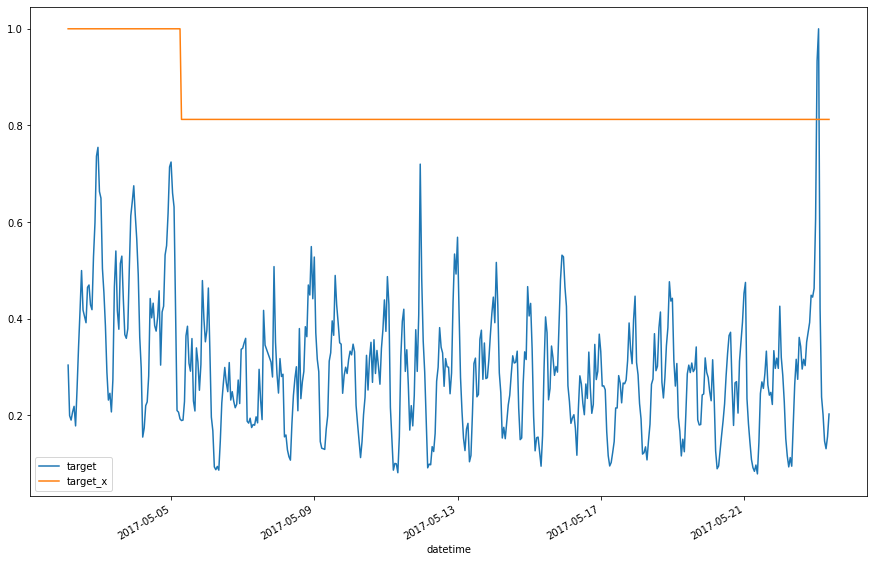

In [110]:
normalised_target_df.plot(x='datetime', figsize=(15,10))

results from test 2: no visible correlation

Test 3:
    Average user count over all network against all candidates individually

In [132]:
candidate_columns = get_candidate_column_names(df)
side_effect_columns = get_all_sideeffect_cols(df, candidate_columns, include_target=True)
cleaned_side_effect_columns = clean_and_convert_to_floats(df, side_effect_columns)
average_user_count_over_all_network = get_sum_of_column_rows(cleaned_side_effect_columns)

In [140]:
test_three_df = pandas.DataFrame()
test_three_df = get_columns(df, candidate_columns)
test_three_df['average_user_count'] = average_user_count_over_all_network

In [143]:
# normalise
normalised_test_three_df = test_three_df.apply(lambda x: x/x.max())
# add date
normalised_test_three_df['datetime'] = time

<AxesSubplot:xlabel='datetime'>

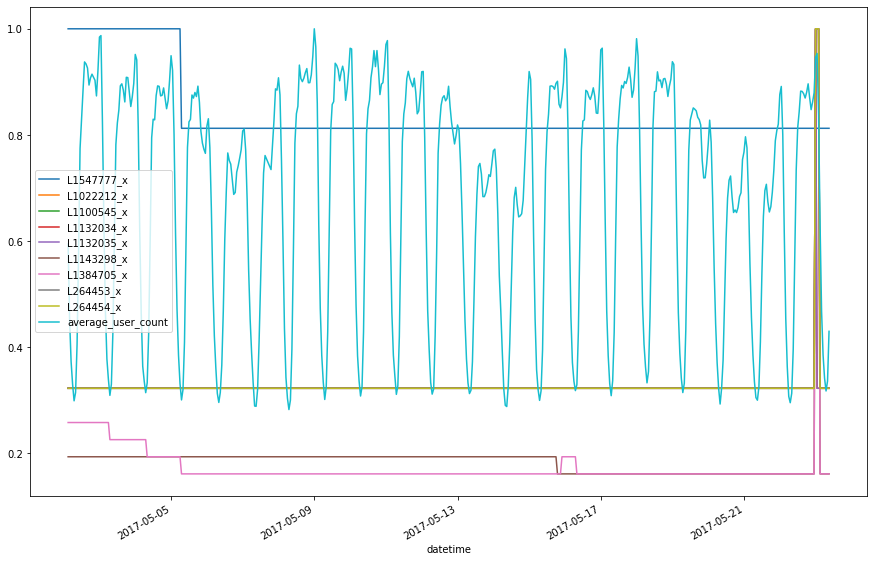

In [145]:
normalised_test_three_df.plot(x='datetime', figsize=(15,10))

Test 4:
    Maybe normalise is not good. Testing using sklearn normalize

In [156]:
test_four_df = test_three_df.copy()
from sklearn import preprocessing
sk_normalized_array = preprocessing.normalize(test_four_df)
normalized_sk_df = pandas.DataFrame(sk_normalized_array, columns=test_four_df.columns)

<AxesSubplot:xlabel='datetime'>

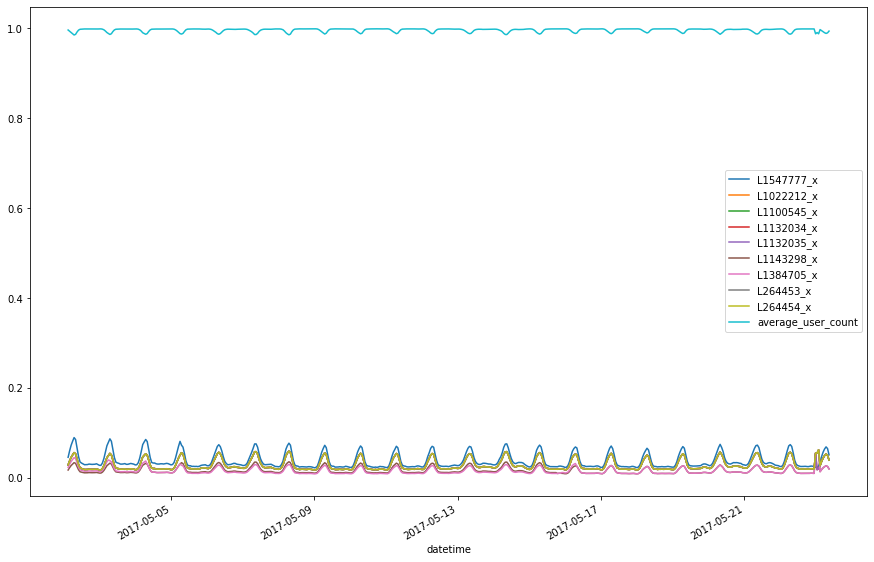

In [160]:
normalized_sk_df['datetime'] = time
normalized_sk_df.plot(x='datetime', figsize=(15,10))

For some reason this shows a dip in average user count when x values spike